# Calculate titers of spike-pseudotyped lentiviruses used for functional mutant validations

In [1]:
import os
import warnings

import math
import numpy as np 

from IPython.display import display, HTML
import matplotlib.pyplot as plt

from neutcurve.colorschemes import CBMARKERS, CBPALETTE
from mizani.formatters import scientific_format

import pandas as pd
from plotnine import *

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config


In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Make output directory if needed

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [5]:
titers = pd.read_csv(config['virus_titers_functional'])

titers = (titers
          .assign(RLUperuL=lambda x: x['RLU_per_well'] / x['uL_virus'],
                  date=lambda x: x['date'].astype(str)
                 )
         )

display(HTML(titers.head().to_html(index=False)))

replicate,virus,dilution,uL_virus,RLU_per_well,date,cells,for_testing,rescue_batch,RLUperuL
rep1,BA1_P1140T,0.125000,12.50000,9310111.0,180722,HEK-ACE2,functional_validation,1,744808.88
rep1,BA1_P1140T,0.062500,6.25000,5212579.0,180722,HEK-ACE2,functional_validation,1,834012.64
rep1,BA1_P1140T,0.031250,3.12500,2640190.0,180722,HEK-ACE2,functional_validation,1,844860.80
rep1,BA1_P1140T,0.015625,1.56250,1173109.0,180722,HEK-ACE2,functional_validation,1,750789.76
rep1,BA1_P1140T,0.007812,0.78125,649025.0,180722,HEK-ACE2,functional_validation,1,830752.00


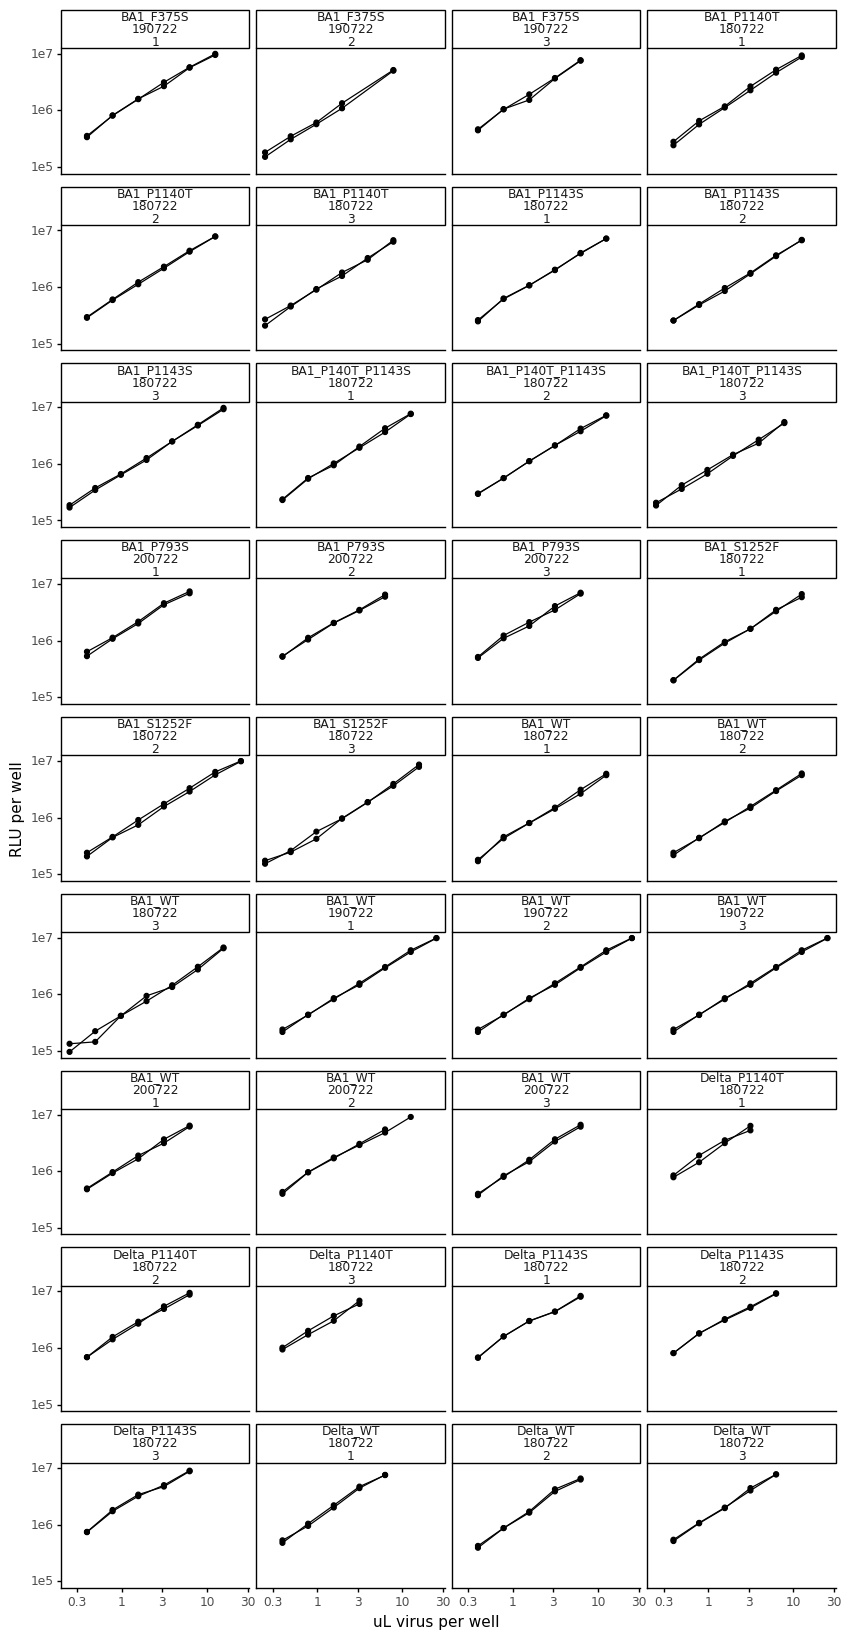

In [6]:
ncol=min(8, titers['virus'].nunique())
nrow=math.ceil(titers['virus'].nunique() / ncol)

p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLU_per_well', group='replicate') +
     geom_point(size=1.5) +
     geom_line() +
     facet_wrap('~virus+date+rescue_batch', ncol=4) +
     scale_y_log10(name='RLU per well') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(10,20),
           )
     )

_ = p.draw()

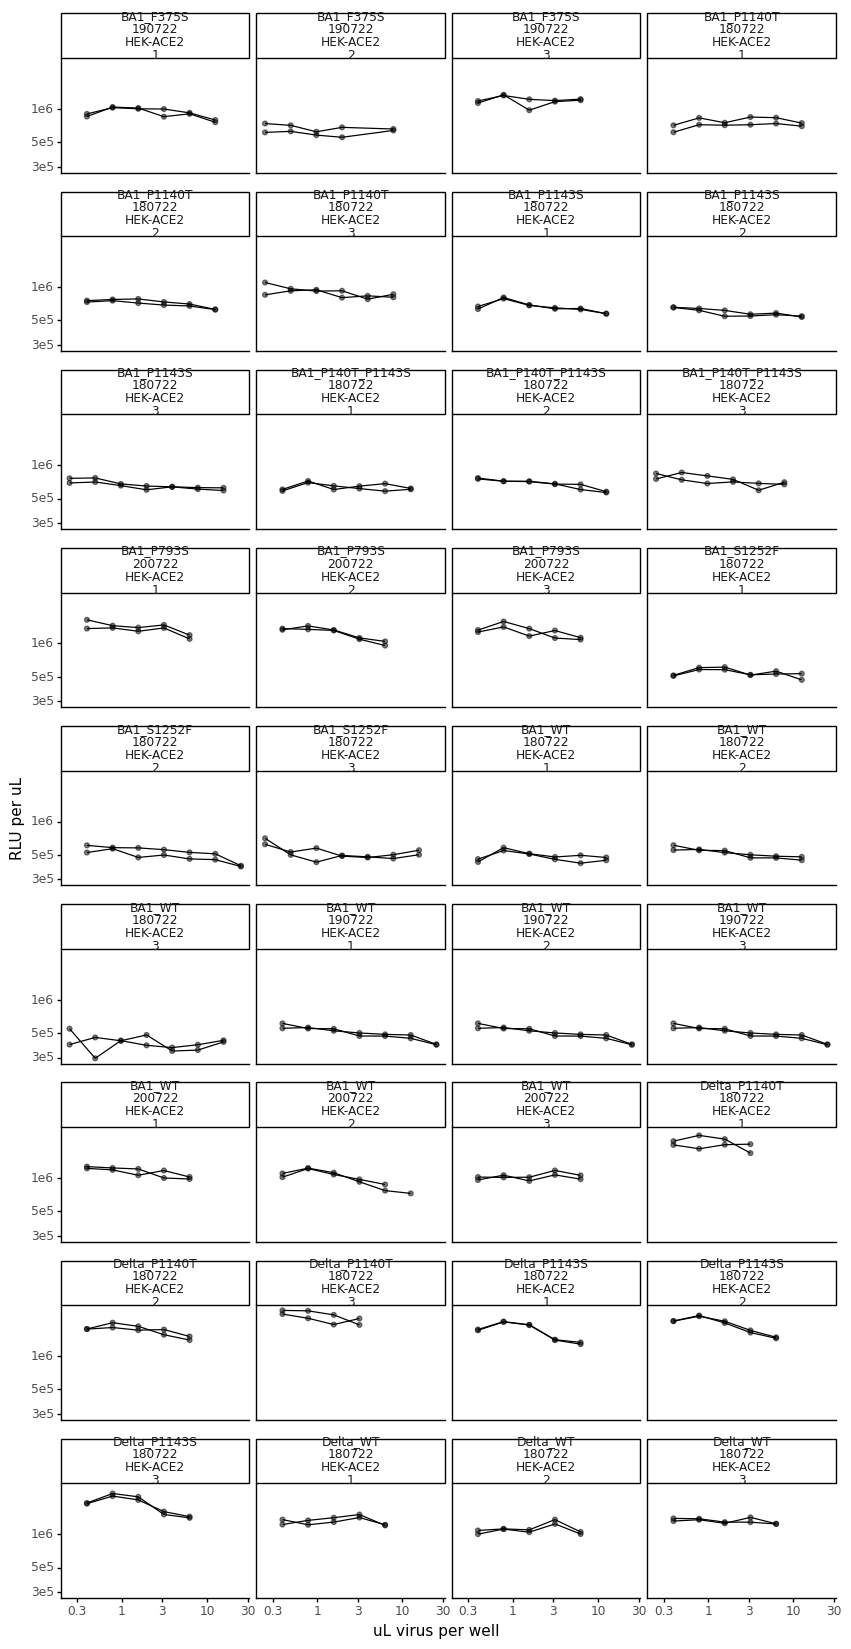

In [7]:
p = (ggplot(titers.dropna()
            ) +
     aes('uL_virus', 'RLUperuL', group='replicate') +
     geom_point(size=1.5, alpha=0.5) +
     geom_line() +
     facet_wrap('~virus+date+cells+rescue_batch', ncol=4) +
     scale_y_log10(name='RLU per uL') +
     scale_x_log10(name='uL virus per well') +
     theme_classic() +
     theme(axis_text_x=element_text(),
           figure_size=(10,20),
           ) 
     )

_ = p.draw()

Check that above plots are approximately linear 

In [8]:
average_titers = (titers
                  .dropna() # missing values for some replicates
#                   .query('uL_virus > 1') # drop concentrations that would not be linear
                  .groupby(['virus', 'date', 'rescue_batch', 'for_testing'])
                  .agg(mean_RLUperuL=pd.NamedAgg(column='RLUperuL', aggfunc=np.mean))
                  .reset_index()
                 )

display(HTML(average_titers.head().to_html(index=False)))

virus,date,rescue_batch,for_testing,mean_RLUperuL
BA1_F375S,190722,1,functional_validation,9.230974e+05
BA1_F375S,190722,2,functional_validation,6.427330e+05
BA1_F375S,190722,3,functional_validation,1.195813e+06
BA1_P1140T,180722,1,functional_validation,7.436016e+05
BA1_P1140T,180722,2,functional_validation,7.144444e+05


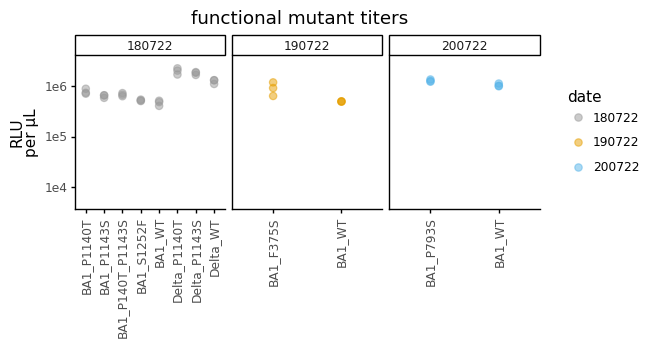

In [9]:
h = (ggplot(average_titers, 
            aes(x='virus', y='mean_RLUperuL', color='date')
           ) +
     geom_point(size=2.5, alpha=0.5)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*0.6,2),
           axis_title_x=element_blank(),
          ) +
     facet_wrap('~date', scales='free_x') +
     ylab('RLU\nper µL')+
     labs(title='functional mutant titers') +
     scale_color_manual(values=CBPALETTE)+
     scale_y_log10(limits=[5e3,3e6])
    )

_ = h.draw()

_.savefig(f'{resultsdir}/functional_virus_titers.pdf', bbox_inches='tight')


In [10]:
average_titers_BA = average_titers[~average_titers.virus.str.contains('|'.join('Delta'))]
average_titers_Delta = average_titers[average_titers.virus.str.contains('|'.join('Delta'))]

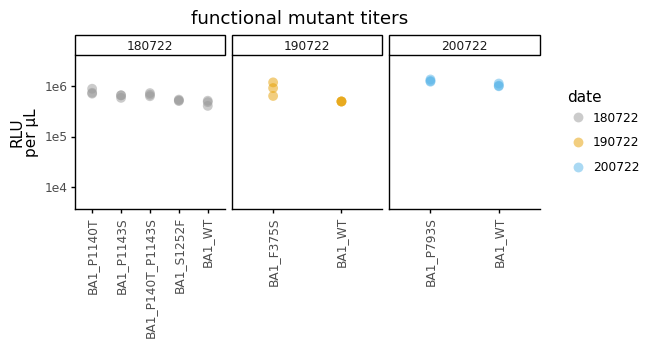

In [11]:
h = (ggplot(average_titers_BA, 
            aes(x='virus', y='mean_RLUperuL', color='date')
           ) +
     geom_point(size=4, alpha=0.5, stroke = 0)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(average_titers['virus'].nunique()*0.6,2),
           axis_title_x=element_blank(),
          ) +
     facet_wrap('~date', scales='free_x') +
     ylab('RLU\nper µL')+
     labs(title='functional mutant titers') +
     scale_color_manual(values=CBPALETTE)+
     scale_y_log10(limits=[5e3,3e6])
    )

_ = h.draw()

_.savefig(f'{resultsdir}/functional_virus_titers_BA1.pdf', bbox_inches='tight')


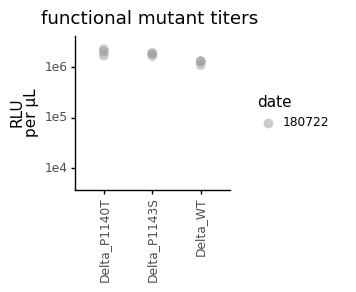

In [18]:
h = (ggplot(average_titers_Delta, 
            aes(x='virus', y='mean_RLUperuL', color='date')
           ) +
     geom_point(size=4, alpha=0.5, stroke = 0)+
     theme_classic() +
     theme(axis_text_x=element_text(angle=90, vjust=1, hjust=0.5),
           figure_size=(2,2),
           axis_title_x=element_blank(),
          ) +
     ylab('RLU\nper µL')+
     labs(title='functional mutant titers') +
     scale_color_manual(values=CBPALETTE)+
     scale_y_log10(limits=[5e3,3e6])
    )

_ = h.draw()

_.savefig(f'{resultsdir}/functional_virus_titers_Delta.pdf', bbox_inches='tight')


In [13]:
target_RLU = 2e5
uL_virus_per_well = 50

dilute_virus = (average_titers
                .groupby(['virus', 'date', 'rescue_batch', 'for_testing'])
                .agg(RLUperuL=pd.NamedAgg(column='mean_RLUperuL', aggfunc=np.mean))
                .reset_index()
                .assign(target_RLU = target_RLU,
                        uL_virus_per_well = uL_virus_per_well,
                        dilution_factor = lambda x: x['RLUperuL']/target_RLU*uL_virus_per_well,
                        uL_per_8mL = lambda x: 8000/x['dilution_factor'],
                        media_for_8ml = lambda x: 8000 - 8000/x['dilution_factor']
                       )
               )


titerfile = os.path.join(resultsdir, 'virus_titers_functional_validations.csv')
print(f"Saving to {titerfile}")

dilute_virus.to_csv(titerfile, index=False)

display(HTML(dilute_virus.to_html(index=False)))

Saving to results/virus_titers_functional_validations.csv


virus,date,rescue_batch,for_testing,RLUperuL,target_RLU,uL_virus_per_well,dilution_factor,uL_per_8mL,media_for_8ml
BA1_F375S,190722,1,functional_validation,9.230974e+05,200000.0,50,230.774348,34.665898,7965.334102
BA1_F375S,190722,2,functional_validation,6.427330e+05,200000.0,50,160.683245,49.787394,7950.212606
BA1_F375S,190722,3,functional_validation,1.195813e+06,200000.0,50,298.953204,26.760041,7973.239959
BA1_P1140T,180722,1,functional_validation,7.436016e+05,200000.0,50,185.900402,43.033796,7956.966204
BA1_P1140T,180722,2,functional_validation,7.144444e+05,200000.0,50,178.611100,44.790049,7955.209951
BA1_P1140T,180722,3,functional_validation,8.939412e+05,200000.0,50,223.485312,35.796536,7964.203464
BA1_P1143S,180722,1,functional_validation,6.646749e+05,200000.0,50,166.168717,48.143839,7951.856161
BA1_P1143S,180722,2,functional_validation,5.898170e+05,200000.0,50,147.454247,54.254117,7945.745883
BA1_P1143S,180722,3,functional_validation,6.604765e+05,200000.0,50,165.119114,48.449872,7951.550128
BA1_P140T_P1143S,180722,1,functional_validation,6.352270e+05,200000.0,50,158.806752,50.375692,7949.624308
